# Business Problem

## Business Situation

The Cardio Catch Diseases Co. is a company specialized in early cardiovascular disease detection running on a business model based in Services, which means that it provides diagnosis for a certain price. These services are made manually by cardio health specialists through a detailed assessment on patients general information and habits plus collected medical examination (blood and pressure exams).

Nowadays the diagnosis precision rate is around 55-65% due to complexity examination and human error. The overall costs involved in diagnosis (personal and equipments) are USD 1000 and the price follow some rules: each 5% increase of precision costs USD 500 on a minimum precision of 50%.
 
**Examples**:
- Diagnosis with precision up to 50% => no costs
- Diagnosis with precision until 55% => USD 500
- Diagnosis with precision until 60% => USD 1000

Since the company face that precision rate fluctuation, the profitability is compromised and it operates sometimes on profit, sometimes in loss which dont give to c-level the cashflow predictability. Therefore, the CEO requested to Data Science team to build a tool capable to enhance the diagnosis precision and give to Cardio Catch Diseases Co a stable cashflow. Moreover, it has been requested a report to show the results, answering some questions:

- What accuracy and precision will be delivered by the new proposed tool?
- How much profit The Cardio Catch Diseases Co. will have with the proposed tool
- Which is the results confidence? 
- How much stability on the cashflow the tool will deliver? 

## Business Understanding & Solution Planning

A) <u>Business problem (open question)</u> - **How could be improved the diagnosis precision?**

B) <u>Business understanding</u>

- **Motivation?** The company are struggling with low profit margins due to a low robustness process diagnosis. Instead of depeding on actual process and specialists (which is manual and delivers instable results), the CEO wants a tool that covers the exams costs and provide a reasonable and stable profitability


- **Root cause**: Increase/stabilize profit margin (and consequently better cashflow) through better diagnosis precision


- **Scope**: (closed affirmation): 
  - Firstly: Build a tool over actual patients data that can deliver better precision and cashflow stability (according to acceptance criteria)
  - Secondarily: Build a comparative report on same data showing the improvement on profit and cashflow estability. 
  
    
- **Stakeholder**? CEO


- **Acceptance Criteria**: Precision 70% ± 5%  

### Solution Planning

**Solution overview**:

 - <u>Kind of problem</u>: Increase on precision diagnosis
 - <u>Potential methods</u>: Classification 


**Output**: 
 - ML model on cloud with API and Streamlit front-end
 - Report on Streamlit with graphs showing comparative profitability and cashflow stability 
 
 
**Steps**:
- Data already collected (Kaggle)
- Understand all data and relationship -> create hypothesis mindmap/pool to explore on EDA
- Develop feature engineering to improve model performance
- Prepare data (rescaling/transformations)
- Feature Selection
- Construct business baseline
- Train ML algorithms and evalute metrics (selecting the best performance)
- <u>If performance meets business needs, move forward. Else, back to develop better features</u>
- HP Fine Tuning
- Translate proposed algorithm performance to business performance (and compare to baseline)
- Create online comparative visualization 
- Deploy ML model service and report visualization on cloud


**Input**:
 - <u>Data Sources</u>: Kaggle

 - Tools: 
   - Languages: Python
   - Main Libs: Pandas, Numpy, Seaborn, Scikitlearn, Streamlit (and other models) 
   - IDEs: Jupyter Nb, 
   - Web: Heroku, Flask, Streamlit

### Project Assumptions

- Diagnosis costs totalize USD 1000
- Business pricing:
  - Precision up to 50% - free of charge. From 50%, every 5% increase costs USD 500
- Baseline will be generated considering random selected precision between 55% and 65%
- 1 year = 365 days
- Normal Blood Pressure Range
- Normal Heights
- Normal Weights

### Others



C) Insights


D) Business Results


E) Conclusion (Objectives reached? Problems faced?)


F) Next Steps

G) Lessons learned

### Data Fields

**FEATURES**
- Id | Identification feature | id | int |
- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |

**TARGET**
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

# 0. Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
import random
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
#from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import confusion_matrix, plot_precision_recall_curve, classification_report, cohen_kappa_score, average_precision_score, precision_recall_curve, f1_score

### 0.1 Helper Functions

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def outlier_detection(data, column):
    
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    
    iqr = q3 - q1

    lo_lim = q1 - 1.5*iqr
    up_lim = q3 + 1.5*iqr
    
    outliers = [x for x in data[column] if (x > up_lim) | (x<lo_lim)]
    
    return sorted(outliers)

#REFACTOR!!
def calculate_profit(data): 
     if data <= 0.50:
        return -1000
     elif (data > 0.50)&(data<=0.55):
        return -500
     elif (data > 0.55)&(data<=0.60):
        return 0
     elif (data > 0.60)&(data<=0.65):
        return 500
     elif (data > 0.65)&(data<=0.70):
        return 1000
     elif (data > 0.70)&(data<=0.75):
        return 1500
     elif (data > 0.75)&(data<=0.80):
        return 2000
     elif (data > 0.80)&(data<=0.85):
        return 2500
     elif (data > 0.85)&(data<=0.90):
        return 3000
     elif (data > 0.9)&(data<=0.95):
        return 3000
     else:
        return 3500

In [4]:
df_raw = pd.read_csv('dataset/cardio_train.csv',sep=';')

In [5]:
df_raw.sample(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
24074,34407,17383,2,172,70.000,110,70,1,1,1,1,1,0
30236,43245,14860,1,169,62.000,110,70,1,1,0,0,1,0
28108,40191,15043,2,168,70.000,110,90,1,1,0,0,0,0
29994,42889,17231,1,165,65.000,120,80,1,1,0,0,1,1
11436,16344,22123,1,159,67.000,140,90,2,2,0,0,1,1
890,1240,19532,1,160,79.000,130,90,2,1,0,0,1,0
3155,4457,18354,1,167,75.000,120,80,1,1,0,0,1,0
27054,38679,14672,2,171,86.000,110,70,2,1,0,0,0,0
48982,69932,22567,2,164,67.000,140,90,1,1,1,0,1,0
34374,49114,21844,1,165,65.000,120,80,1,1,0,0,1,0


# 1. Data Description

### 1.0 Data Dimensions

In [6]:
df = df_raw.copy()

In [7]:
print('The dataset contains {} rows and {} features'.format(df.shape[0],df.shape[1]))

The dataset contains 70000 rows and 13 features


### 1.1 Test set split

In [8]:
X = df_raw.drop(columns='cardio',axis=1)
y = df_raw['cardio']
x1, X_test, y1, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
df = pd.concat([x1,y1],axis=1)

### 1.2 Data Types

In [9]:
df.dtypes # data types seems ok

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

### 1.3 Check Missing Data

In [10]:
df.isna().sum() # no missing data

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56000 entries, 47339 to 15795
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           56000 non-null  int64  
 1   age          56000 non-null  int64  
 2   gender       56000 non-null  int64  
 3   height       56000 non-null  int64  
 4   weight       56000 non-null  float64
 5   ap_hi        56000 non-null  int64  
 6   ap_lo        56000 non-null  int64  
 7   cholesterol  56000 non-null  int64  
 8   gluc         56000 non-null  int64  
 9   smoke        56000 non-null  int64  
 10  alco         56000 non-null  int64  
 11  active       56000 non-null  int64  
 12  cardio       56000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.0 MB


### 1.4 Check Structural Problems

In [12]:
cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

In [13]:
for col in cols:
    print(col, sorted(df[col].unique()))
    print('\n')

age [10798, 10859, 10878, 10964, 14275, 14277, 14287, 14291, 14292, 14293, 14294, 14295, 14296, 14297, 14300, 14301, 14302, 14303, 14305, 14306, 14307, 14308, 14309, 14310, 14311, 14313, 14314, 14315, 14319, 14321, 14322, 14323, 14324, 14325, 14326, 14328, 14329, 14330, 14331, 14332, 14333, 14334, 14335, 14336, 14337, 14338, 14339, 14341, 14342, 14343, 14344, 14345, 14346, 14347, 14348, 14349, 14350, 14351, 14352, 14354, 14355, 14356, 14357, 14358, 14359, 14360, 14361, 14362, 14363, 14364, 14365, 14366, 14367, 14368, 14369, 14370, 14371, 14372, 14373, 14374, 14375, 14376, 14377, 14378, 14379, 14380, 14382, 14383, 14384, 14385, 14386, 14387, 14388, 14390, 14391, 14392, 14393, 14394, 14395, 14396, 14397, 14398, 14399, 14400, 14401, 14402, 14403, 14404, 14405, 14406, 14407, 14408, 14409, 14410, 14411, 14412, 14413, 14414, 14415, 14416, 14417, 14418, 14419, 14420, 14421, 14422, 14423, 14424, 14425, 14426, 14427, 14428, 14429, 14430, 14431, 14432, 14433, 14434, 14435, 14436, 14437, 14438, 1

#### 1.4.1 Fix Structural Problems

In [14]:
# transform age in days

df['age'] = df['age'].apply(lambda x: int(x/365))

In [15]:
# ap_hi and ap_lo negatives => ap_hi neg 7 records / ap_lo neg 1 record 
# Assumption: typo => transform to positive

df['ap_hi'] = df['ap_hi'].apply(lambda x: x*(-1) if x < 0 else x)
df['ap_lo'] = df['ap_lo'].apply(lambda x: x*(-1) if x < 0 else x)

### 1.5 Check Duplicates / Low variation Data

In [16]:
df[df['id'].duplicated()]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


In [17]:
col_low_var = ['cholesterol', 'gluc', 'smoke', 'alco', 'active']

for col in col_low_var:
    print(col,"\n", df[col].value_counts())
    print('\n')

cholesterol 
 1    41910
2     7668
3     6422
Name: cholesterol, dtype: int64


gluc 
 1    47619
3     4216
2     4165
Name: gluc, dtype: int64


smoke 
 0    51030
1     4970
Name: smoke, dtype: int64


alco 
 0    52929
1     3071
Name: alco, dtype: int64


active 
 1    45011
0    10989
Name: active, dtype: int64




### 1.6 Check Outliers / Business knowledge data

In [18]:
cols_out = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

for col in cols_out:
    print(col, outlier_detection(df, col))
    print('\n')

age [29, 29, 29, 30]


height [55, 59, 60, 64, 65, 65, 67, 67, 67, 68, 70, 70, 71, 72, 74, 75, 80, 81, 91, 96, 99, 100, 100, 104, 104, 105, 105, 108, 109, 110, 110, 110, 110, 110, 110, 111, 112, 113, 117, 117, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 122, 125, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 131, 132, 132, 133, 133, 133, 133, 133, 134, 135, 135, 135, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 187, 187, 187, 187, 187, 187, 187, 

In [19]:
#heights out of range => height < 100cm will be disregard => 26 records
# Assumption: mismeasurement => drop heights less than 100cm

df = df[~(df['height'] < 100)]

In [20]:
#weights out of range => weight < 40kg will be disregard => 50 records
# Assumption: mismeasurement => drop weights less than 40kg

df = df[~(df['weight'] < 40)]

In [21]:
#ap_hi and ap_lo out normal range (min systolic/diastolic  75<ap_hi<200 and 50<ap_lo<140) => 1.8% of dataset => 
# Assumption: mismeasurement => drop records

df = df[~((df['ap_lo'] < 50 ) | (df['ap_lo'] > 140 ) | (df['ap_hi'] > 200) | (df['ap_hi'] < 75))]

### 1.7 Check Target Proportion

In [22]:
df['cardio'].value_counts() #seems dataset on target variable is balanced

0    27738
1    27143
Name: cardio, dtype: int64

# 2. Descriptive Statistics

In [23]:
df2 = df.copy()

In [24]:
df2.agg(["min","max","mean","median","std","skew","kurtosis"]).drop(columns='id').T.reset_index().rename(columns= {'index' : 'features'})

,features,min,max,mean,median,std,skew,kurtosis
0,age,29.000,64.000,52.815,53.000,6.776,-0.302,-0.821
1,gender,1.000,2.000,1.349,1.000,0.477,0.632,-1.600
2,height,100.000,250.000,164.392,165.000,7.969,-0.050,1.527
3,weight,40.000,200.000,74.125,72.000,14.251,1.019,2.560
4,ap_hi,80.000,200.000,126.552,120.000,16.538,0.834,1.318
5,ap_lo,50.000,140.000,81.325,80.000,9.444,0.389,1.795
6,cholesterol,1.000,3.000,1.364,1.000,0.678,1.600,1.038
7,gluc,1.000,3.000,1.224,1.000,0.569,2.416,4.393
8,smoke,0.000,1.000,0.089,0.000,0.284,2.894,6.374
9,alco,0.000,1.000,0.055,0.000,0.227,3.921,13.377


# 3. Feature Engineering

In [25]:
df3 = df2.copy()

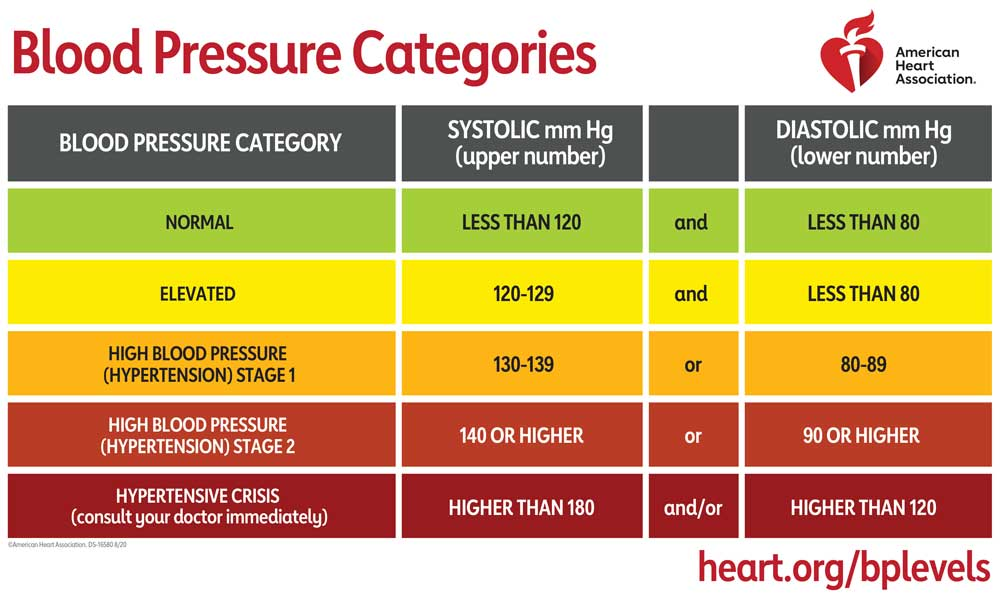

In [26]:
Image('img\\blood-pressure-readings-chart.jpg',width=600, height=400)

In [27]:
#new feature qualitative combining ap-lo ap-hi - {'normal':0,'elevated':1,'high bp lvl1':2, 'high bp lvl2':3, 'hypertensive:4}

categ_blood_pressure = lambda x: 0 if (x['ap_hi'] < 120)&(x['ap_lo']<80) else 1 if ((x['ap_hi'] >= 120)&(x['ap_hi'] < 130))&(x['ap_lo']<80) else 2 if ((x['ap_hi'] >= 130)&(x['ap_hi'] < 140))|((x['ap_lo']>=80)&(x['ap_lo']<90)) else 3 if ((x['ap_hi'] >= 140)&(x['ap_hi'] < 180))|((x['ap_lo']>=90)&(x['ap_lo']<120)) else 4

df3['bp_class'] = df3.apply(categ_blood_pressure,axis=1)                             

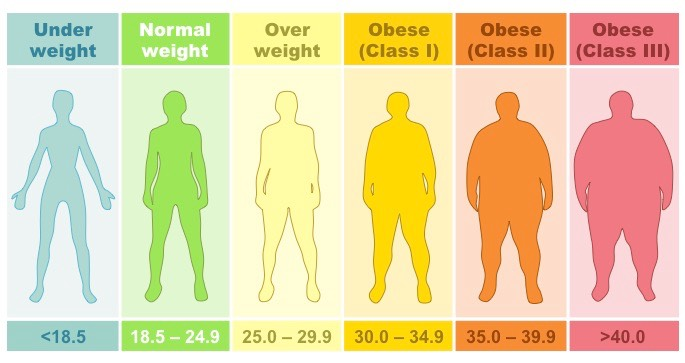

In [28]:
Image('img\\bmi-classification.jpeg',width=600, height=400)

In [29]:
#new feature qualitative bmi/bmi class - underweight':0,'normal weight':1,'overweight':2, 'obese I':3, 'obese II':4,'obese III':5
categ_weight = lambda x: 0 if x < 18.5 else 1 if x < 25 else 2 if x < 30 else 3 if x < 35 else 4 if x < 40 else 5

df3['bmi'] = np.round(df3['weight'] / np.exp2(df3['height']/100),2)
df3['bmi_class'] = df3['bmi'].apply(categ_weight)

In [30]:
df3 = df3[['id', 'age','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','bp_class','bmi','bmi_class','cardio']]

# 3. Exploratory Data Analysis

## 3.1 Hypotesys Exploration

**H1.** Patients with high blood pressure combined to high cholesterol represents 60% of cardiovascular diseases

**FALSE** - Patients with high BP and cholesterol represent 30%

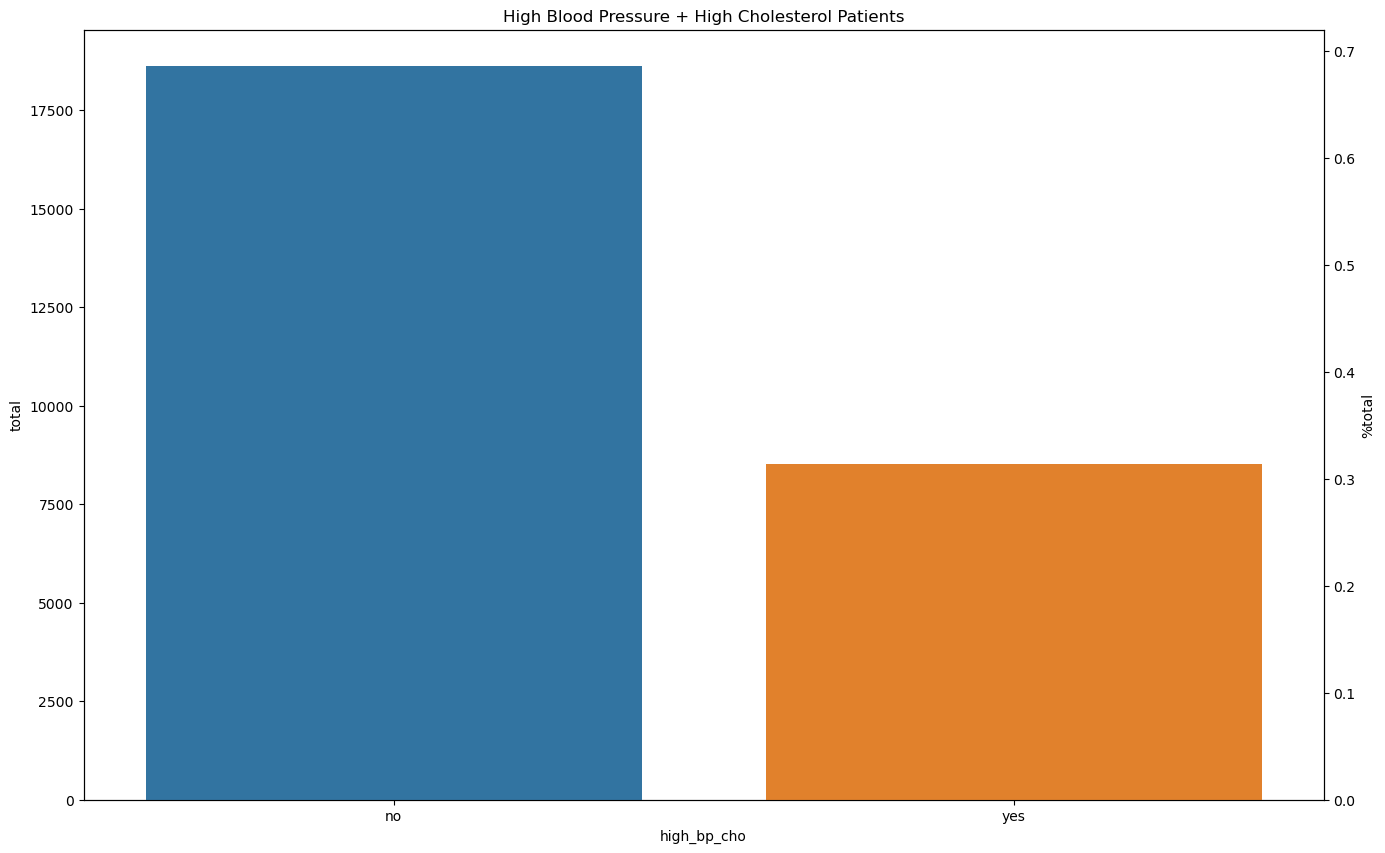

In [31]:
# data filtering
high_bp = [2,3,4]
high_cho = [2,3]

aux1 = df3[df3['cardio']==1] 
aux1['high_bp_cho'] = aux1.apply(lambda x: 'yes' if ((x['bp_class'] in high_bp) & (x['cholesterol'] in high_cho)) else 'no', axis=1)
aux10 = aux1.groupby(['high_bp_cho','cardio']).size().reset_index().rename(columns={0:'total'})
sum_total = aux10['total'].sum()
aux10['%total'] = aux10['total']/sum_total

# data ploting
fig,ax = plt.subplot_mosaic('A',figsize=(16,10))
ax2 = ax['A'].twinx()
sns.barplot(data=aux10, x='high_bp_cho', y='total', ax=ax['A'])
sns.barplot(data=aux10, x='high_bp_cho', y='%total', ax=ax2)
ax['A'].set_title('High Blood Pressure + High Cholesterol Patients');

**H2.** Sedentary elder people have 40% more chances to have cardio problems than elder active people 

**FALSE** Sedentary elder people are 56% more likely to face heart conditions (as much as the rest of population)

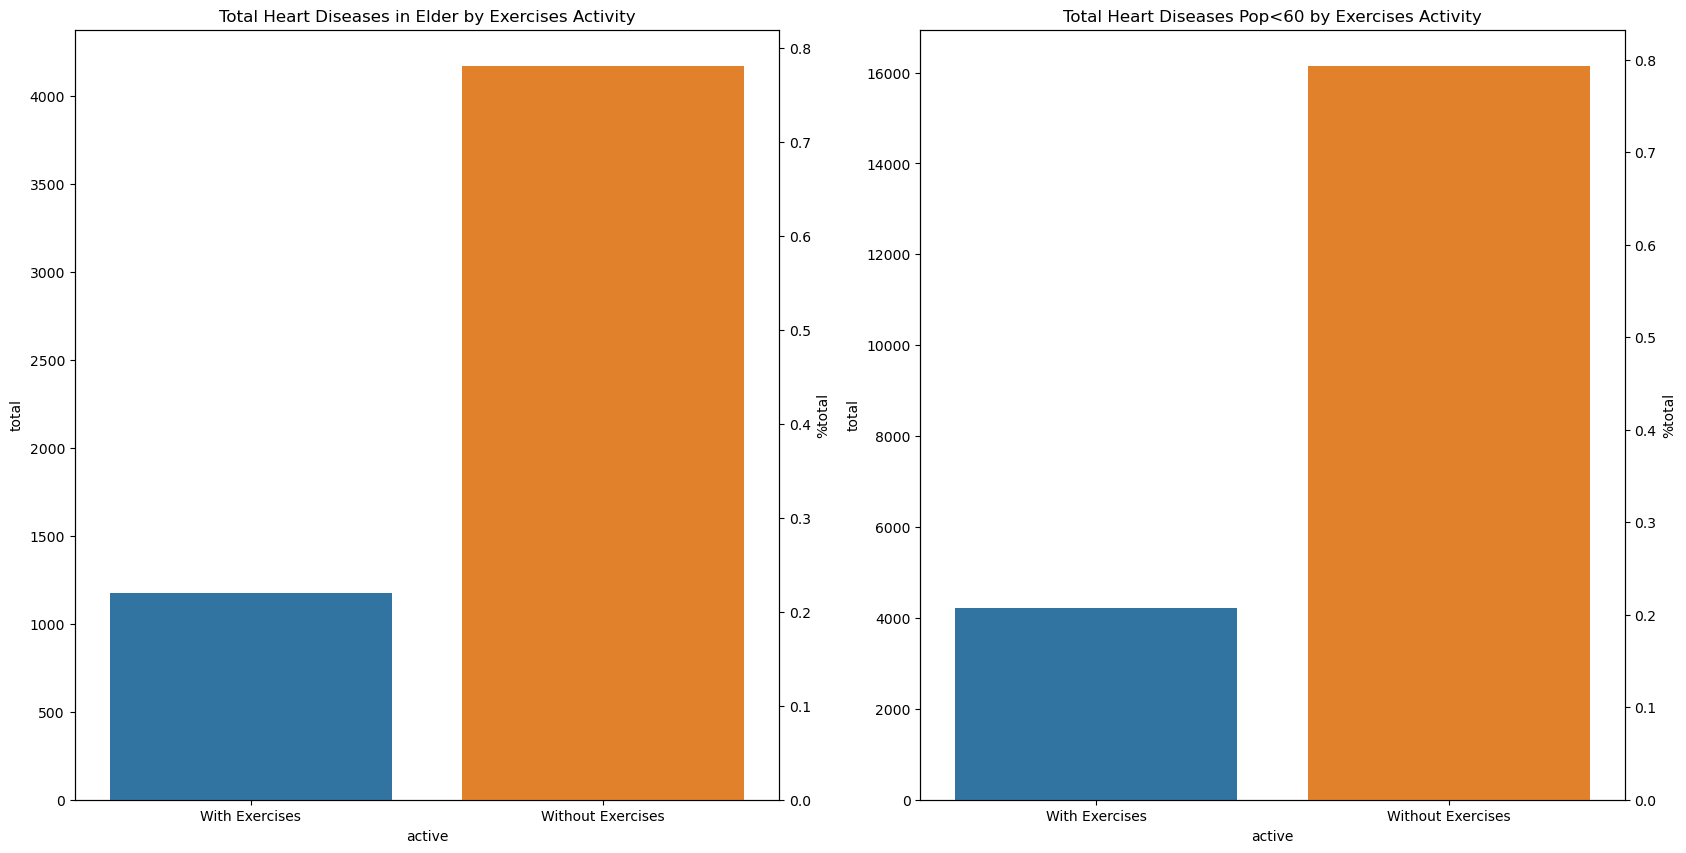

In [32]:
aux2 = df3[df3['age']>60]
aux22 = aux2.groupby(['active','cardio']).size().reset_index().rename(columns={0:'total'})
aux23 = aux22[aux22['cardio']==1]
sum_total = aux23['total'].sum()
aux23['%total'] = aux23['total']/sum_total

aux02 = df3[df3['age']<60]
aux24 = aux02.groupby(['active','cardio']).size().reset_index().rename(columns={0:'total'})
aux25 = aux24[aux24['cardio']==1]
sum_total = aux25['total'].sum()
aux25['%total'] = aux25['total']/sum_total


fig, ax = plt.subplot_mosaic("AB", figsize=(20, 10))
sns.barplot(data=aux23, x='active', y='total', ax=ax['A'])
ax2 = ax['A'].twinx()
sns.barplot(data=aux23, x='active', y='%total',ax=ax2);
ax['A'].set_title('Total Heart Diseases in Elder by Exercises Activity')

sns.barplot(data=aux25, x='active', y='total', ax=ax['B'])
ax3 = ax['B'].twinx()
sns.barplot(data=aux25, x='active', y='%total',ax=ax3);
ax['B'].set_title('Total Heart Diseases Pop<60 by Exercises Activity')


labels = [item.get_text() for item in ax['A'].get_xticklabels()]
labels[0] = 'With Exercises'
labels[1] = 'Without Exercises'

ax['A'].set_xticklabels(labels);
ax['B'].set_xticklabels(labels);



**H3.** Men have 30% more heart diseases than women 

**TRUE**

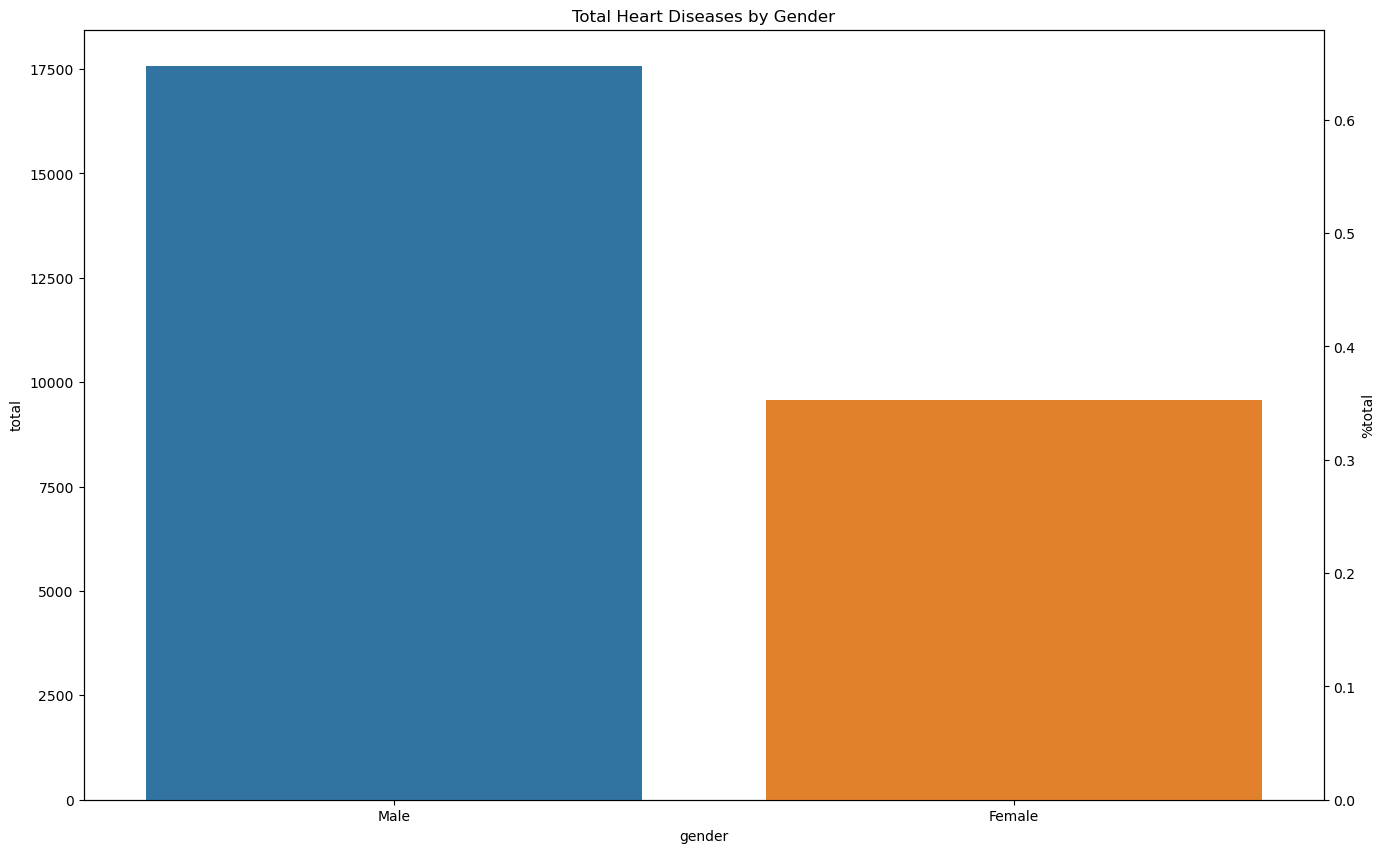

In [33]:
aux3 = df3.groupby(['gender','cardio']).size().reset_index().rename(columns={0:'total'})
aux33 = aux3[aux3['cardio']==1]
sum_tot = aux33['total'].sum()
aux33['%total'] = aux33['total']/sum_tot

fig, ax = plt.subplot_mosaic("A", figsize=(16,10))
sns.barplot(data=aux33, x='gender', y='total', ax=ax['A'])

ax2 = ax['A'].twinx()

sns.barplot(data=aux33, x='gender', y='%total',ax=ax2);
ax['A'].set_title('Total Heart Diseases by Gender')
# ax['B'].set_title('% Heart Diseases by Gender')


labels = [item.get_text() for item in ax['A'].get_xticklabels()]
labels[0] = 'Male'
labels[1] = 'Female'

ax['A'].set_xticklabels(labels);
#ax['B'].set_xticklabels(labels)

**H4.** People framed into obesity (I, II, III) represents 60% of total cardiovascular diseases

**FALSE** Obesity doesn't define cardio vascular disease -> 11% of total cardio diseases

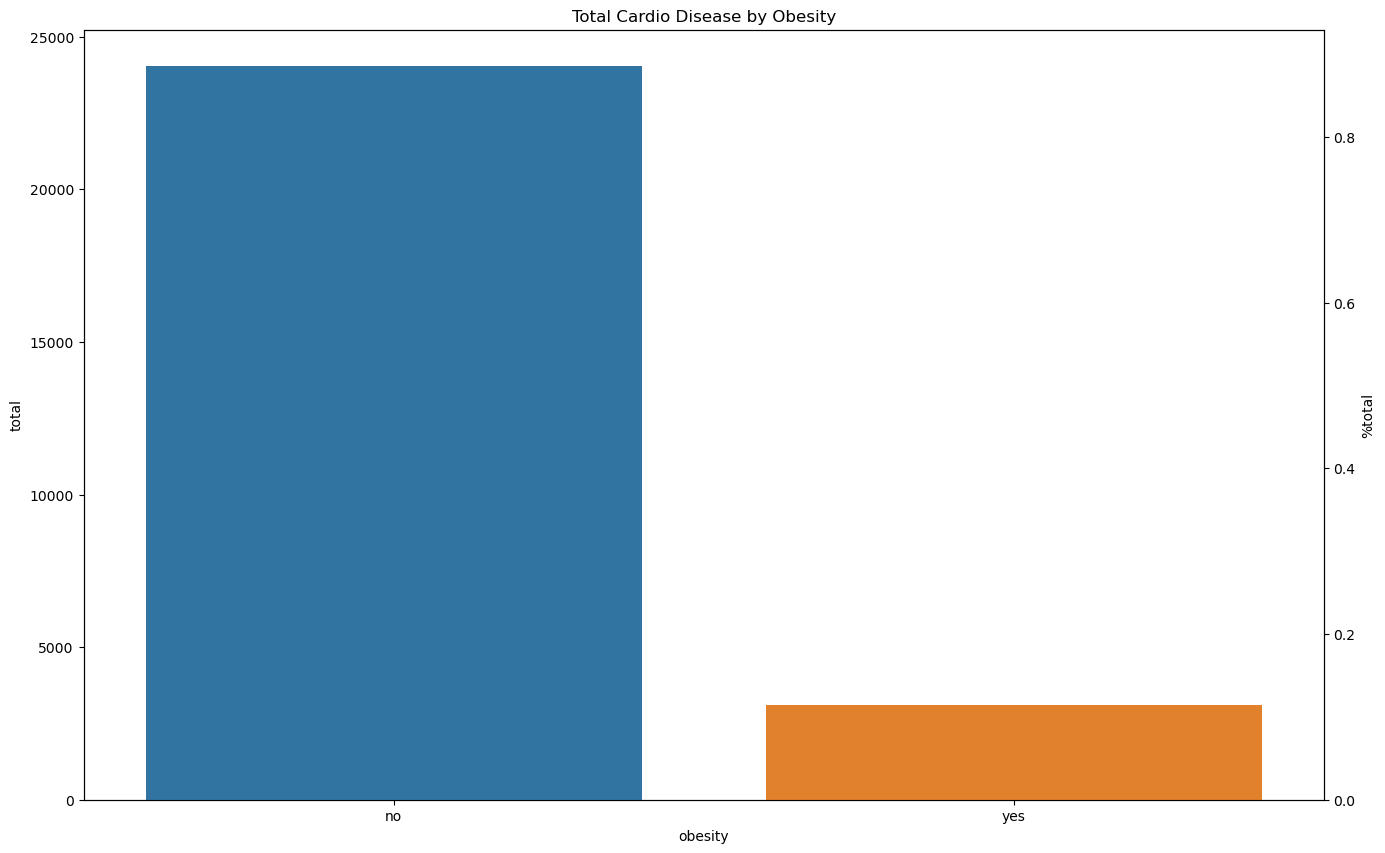

In [34]:
obese_group = [3,4,5]
aux4 = df3[['bmi_class','cardio']]
aux4['obesity'] = aux4['bmi_class'].apply(lambda x: 'yes' if x in obese_group else 'no')

aux41 = aux4.groupby(['obesity','cardio']).size().reset_index().rename(columns={0:'total'})
aux41 = aux41[aux41['cardio']==1]
aux41['%total'] = aux41['total']/np.sum(aux41['total']) 

fig, ax = plt.subplot_mosaic("A", figsize=(16,10))
ax2 = ax['A'].twinx()
sns.barplot(data=aux41, x='obesity',y='total',ax=ax['A'])
sns.barplot(data=aux41, x='obesity',y='%total',ax=ax2)

ax['A'].set_title('Total Cardio Disease by Obesity');

**H5.** Alcohol associated to smoking habits increase 30% heart problems compared to non-alcoholist and no smokers

**FALSE** Alcohol plus smoking aren't the main reason for heart problems -> 2% of total heart diseases

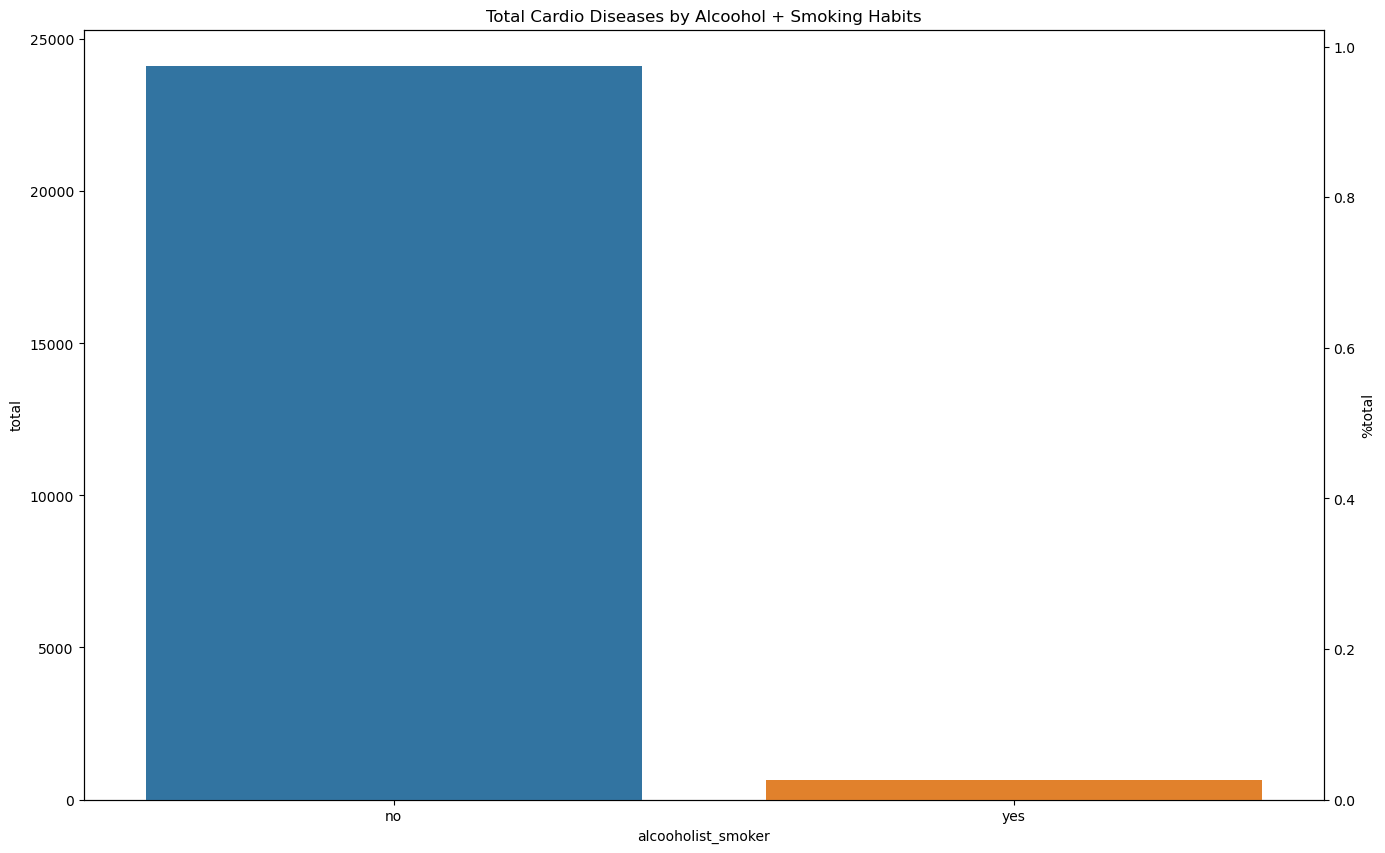

In [35]:
aux5 = df3.groupby(['alco','smoke','cardio']).size().reset_index().rename(columns={0:'total'})
aux51 = aux5[(aux5['cardio']==1) # patients with cardio diseases
             &((aux5['alco']==1)&(aux5['smoke']==1)|(aux5['alco']==0)&(aux5['smoke']==0))] #only alcoholist smoker or not
aux51['alcooholist_smoker'] = aux51.apply(lambda x: 'yes' if (x['alco']==1)&(x['smoke']==1) else 'no',axis=1)
aux51['%total'] = aux51['total']/np.sum(aux51['total']) 

fig, ax = plt.subplot_mosaic("A", figsize=(16,10))
ax2 = ax['A'].twinx()

sns.barplot(data=aux51, x='alcooholist_smoker', y='total', ax=ax['A'])
sns.barplot(data=aux51, x='alcooholist_smoker', y='%total',ax=ax2)

ax['A'].set_title('Total Cardio Diseases by Alcoohol + Smoking Habits');

**H6.** High blood pressure associated with smoking habits represents 50% of cardiovascular disease compared to non

**FALSE** High blood pressure associated with smoking habits represents 3%

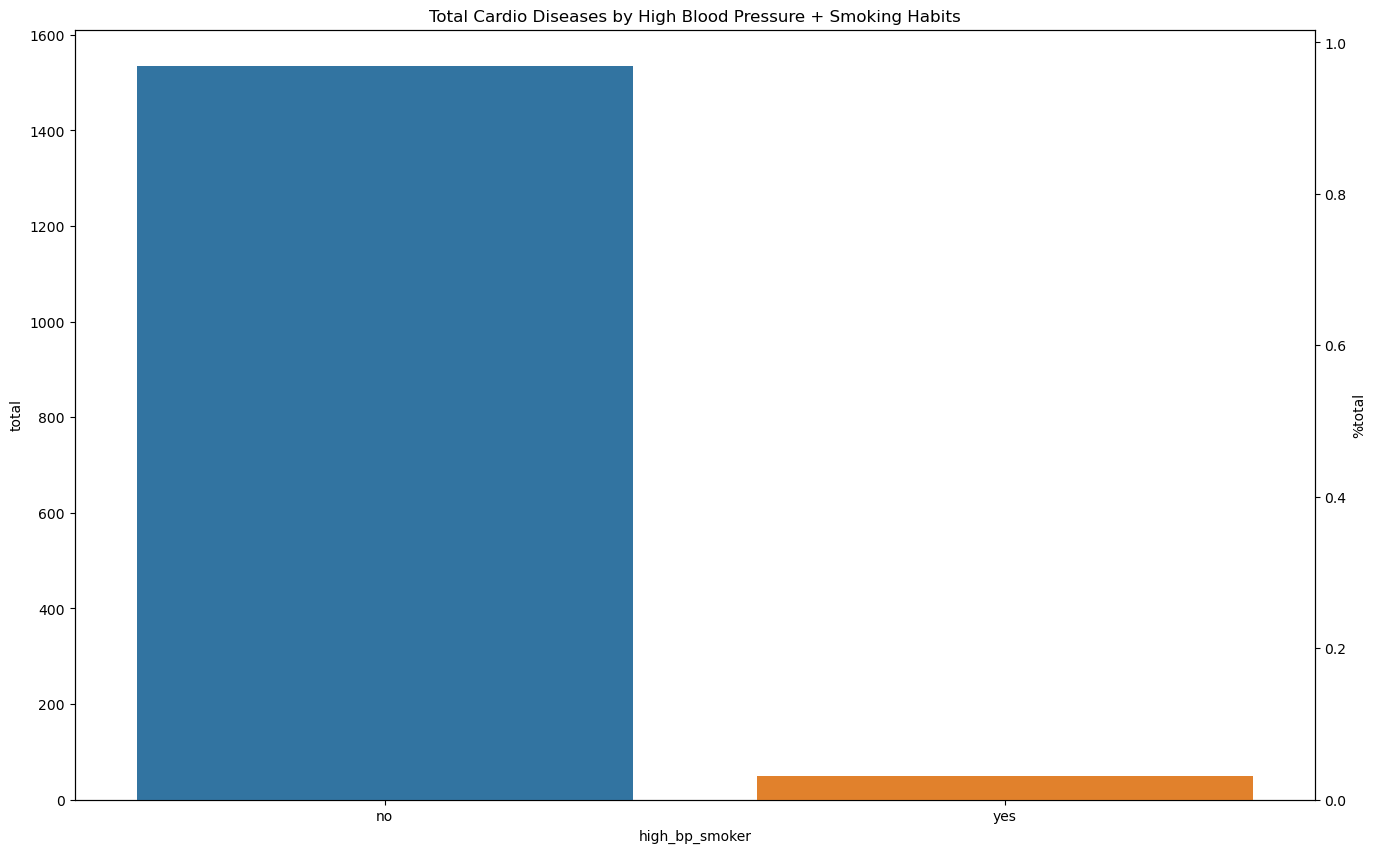

In [36]:
aux6 = df3.groupby(['bp_class','smoke','cardio']).size().reset_index().rename(columns={0:'total'})
aux61 = aux6[(aux6['cardio']==1)                          # patients with cardio diseases
             &((aux6['bp_class']==1)&(aux6['smoke']==1)   # only high blood pressure and smoker
             |(aux6['bp_class']==0)&(aux6['smoke']==0))]  # w/o high blood pressure and smoker
aux61['high_bp_smoker'] = aux61.apply(lambda x: 'yes' if (x['bp_class']==1)&(x['smoke']==1) else 'no',axis=1)

aux61['%total'] = aux61['total']/np.sum(aux61['total']) 

fig, ax = plt.subplot_mosaic("A", figsize=(16,10))
ax2 = ax['A'].twinx()

sns.barplot(data=aux61, x='high_bp_smoker', y='total',ax=ax['A'] )
sns.barplot(data=aux61, x='high_bp_smoker', y='%total',ax=ax2 )

ax['A'].set_title('Total Cardio Diseases by High Blood Pressure + Smoking Habits');

**H7.** High glucose is found in 20% of all patients with cardio disease

**TRUE**

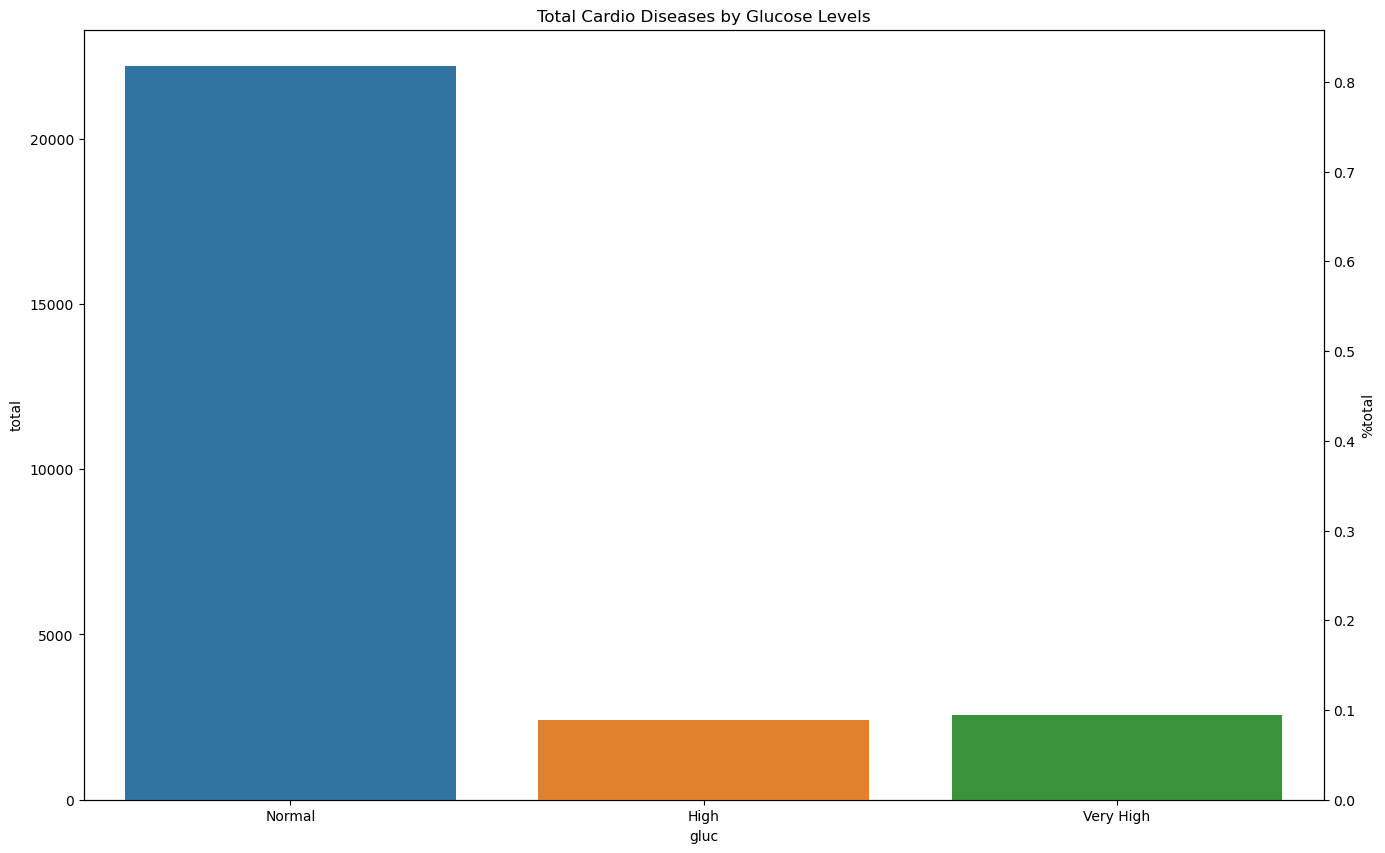

In [37]:
aux7 = df3[df3['cardio']==1]
aux71 = aux7.groupby('gluc').size().reset_index().rename(columns={0:'total'})
aux71['%total'] = aux71['total'] / np.sum(aux71['total'])

fig, ax = plt.subplot_mosaic("A", figsize=(16,10))
ax2 = ax['A'].twinx()

sns.barplot(data=aux71, x='gluc', y='total',ax=ax['A'] )
sns.barplot(data=aux71, x='gluc', y='%total',ax=ax2 )

ax['A'].set_title('Total Cardio Diseases by Glucose Levels')

labels = [item.get_text() for item in ax['A'].get_xticklabels()]
labels[0] = 'Normal'
labels[1] = 'High'
labels[2] = 'Very High'

ax['A'].set_xticklabels(labels);

**H8.** Shorter patients (<145) have 30% more heart problems than tall patients (>185)

**FALSE** Being shorter or taller don't affect the likelihood (50%/50%)

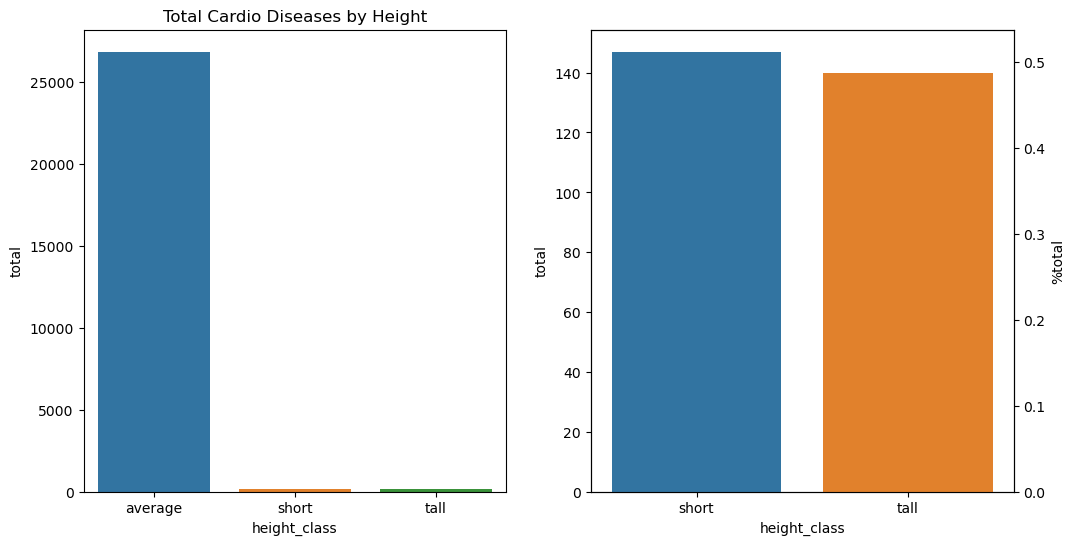

In [38]:
aux8 = df3[df3['cardio']==1]
aux8['height_class'] = aux8['height'].apply(lambda x: 'short' if x<145 else
                                           'tall' if x>185 else 'average')
aux81 = aux8.groupby('height_class').size().reset_index().rename(columns={0:'total'})
aux82 = aux81[aux81['height_class'].isin(['short', 'tall'])]
aux82['%total'] = aux82['total'] / np.sum(aux82['total'])

fig, ax = plt.subplot_mosaic('AB', figsize=(12,6))
ax2 = ax['B'].twinx()

sns.barplot(data=aux81, x='height_class',y='total',ax=ax['A'])
sns.barplot(data=aux82, x='height_class',y='total',ax=ax['B'])
sns.barplot(data=aux82, x='height_class',y='%total',ax=ax2)

ax['A'].set_title('Total Cardio Diseases by Height');

**H9.** Patients older than 50 years represents more than 70% of total cardiovascular problems

**TRUE**

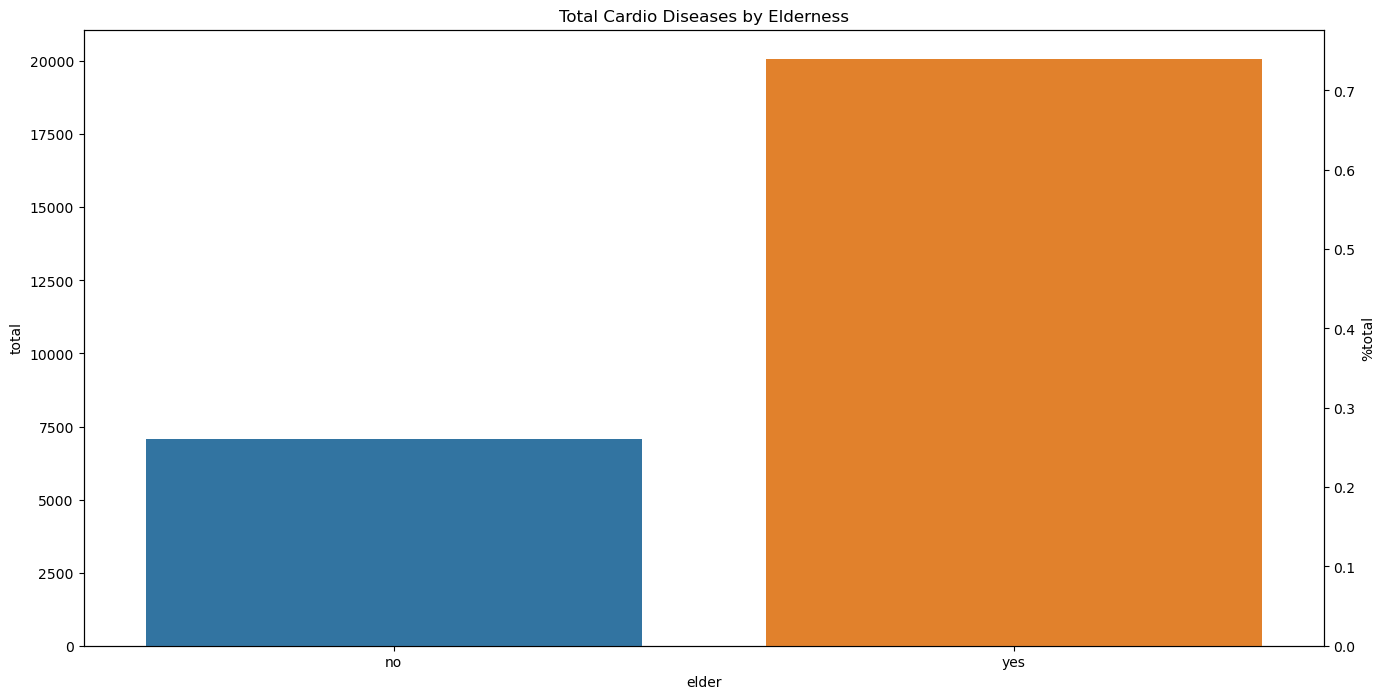

In [39]:
aux9 = df3[df3['cardio']==1]
aux9['elder'] = aux9['age'].apply(lambda x: 'yes' if x>50 else 'no')
aux91 = aux9.groupby('elder').size().reset_index().reset_index().rename(columns={0:'total'})
aux91['%total'] = aux91['total'] / np.sum(aux91['total'])

fig, ax = plt.subplot_mosaic('A', figsize=(16,8))
ax2 = ax['A'].twinx()

sns.barplot(data=aux91, x='elder',y='total',ax=ax['A'])
sns.barplot(data=aux91, x='elder',y='%total',ax=ax2)

ax['A'].set_title('Total Cardio Diseases by Elderness');

**H10.** Obese smokers represents have 30% more heart problems than obese non-smokers

**FALSE** Obese smokers represents 1% of cardio diseases

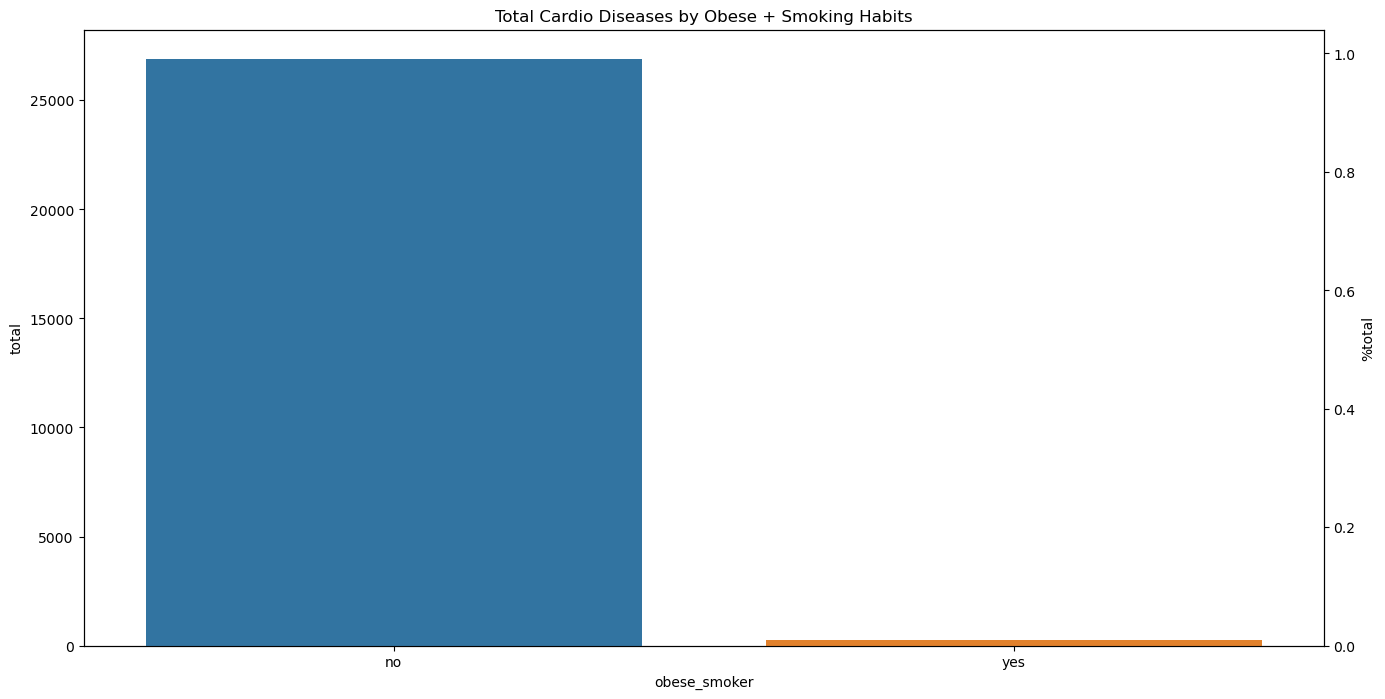

In [40]:
obese = [3,4,5]
aux10 = df3[df3['cardio']==1]
aux10['obese_smoker'] = df3.apply(lambda x: 'yes' if ((x['bmi_class']==3)|(x['bmi_class']==4)|(x['bmi_class']==5))&(x['smoke'] == 1) else 'no',axis=1)
aux11 = aux10.groupby('obese_smoker').size().reset_index().rename(columns={0:'total'})
aux11['%total'] = aux11['total'] / np.sum(aux11['total'])

fig, ax = plt.subplot_mosaic('A', figsize=(16,8))
ax2 = ax['A'].twinx()

sns.barplot(data=aux11, x='obese_smoker',y='total',ax=ax['A'])
sns.barplot(data=aux11, x='obese_smoker',y='%total',ax=ax2)

ax['A'].set_title('Total Cardio Diseases by Obese + Smoking Habits');

#### Insights

- 
- Tried to understand health problems associations in order to propose new features (more meaningful)

- Business Insights:
    - High blood pressure and cholesterol have high representation (30%) on cardio disease compared to others associations
    - Obesity have relevant representation on cardio disease (11%)
    - Sedentarism is a critical factor to cardio diseases
    - Age associated to other factors define cardio diseases 
    - 2 factores association is not the most


## 3.2 Uni / Bi / Multivariate Analysis

In [41]:
#profile = ProfileReport(df3)
#profile.to_file('EDA.html')

- Modeling Insights:
    - Derived features: some features (bmi/bmi_class, bp_class)  were derived from original (height,weight,ap_hi,ap_lo) features and have high correlation, evaluate drop it. 
    - gender and smoke high correlated
    - glucose and cholesterol high correlated
    - alco and smoke high correlated
    - ap_hi is directly correlated to target variable
    
**In this 1st crisp cycle, we wil let feature selection algo to show most relevant features to pick**

# 4.0 Data Preparation

In [42]:
df4 = df3.copy()

## 4.1 Split Train/Validation

In [43]:
X = df4.drop(columns=['id','cardio'])
y = df4['cardio']
print('O tamanho de X é {} e de y é {}'.format(X.shape, y.shape))


X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)
print('O tamanho de X_train é {} e de X_val é {}'.format(X_train.shape, X_test.shape))
print('O tamanho de y_train é {} e de y_val é {}'.format(y_train.shape, y_test.shape))

O tamanho de X é (54881, 14) e de y é (54881,)
O tamanho de X_train é (43904, 14) e de X_val é (14000, 12)
O tamanho de y_train é (43904,) e de y_val é (14000,)


## 4.2 Rescaling

In [44]:
already_encoded_cat = ['gender', 'cholesterol', 'gluc',  'smoke',  'alco', 'active', 'bp_class', 'bmi_class']

#some extreme values
rob_scaler_feats = ['ap_hi',  'ap_lo']

#range defined
minmax_scaler_feats = ['age']

#normal distributed
std_scaler_feats = ['height', 'weight', 'bmi' ]

ct = ColumnTransformer(
    [("robust", RobustScaler(), rob_scaler_feats),
     ("minmax", MinMaxScaler(), minmax_scaler_feats),
     ("standard", StandardScaler(),std_scaler_feats)
    ], remainder='passthrough')


X_train_scaled = pd.DataFrame(ct.fit_transform(X_train), columns=['ap_hi', 'ap_lo','age','height', 'weight', 'bmi','gender', 'cholesterol', 'gluc',  'smoke',  'alco', 'active', 'bp_class', 'bmi_class'],index=X_train.index)
X_train_scaled = X_train_scaled[X.columns.to_list()]
X_val_scaled = pd.DataFrame(ct.transform (X_val),columns=['ap_hi', 'ap_lo','age','height', 'weight', 'bmi','gender', 'cholesterol', 'gluc',  'smoke',  'alco', 'active', 'bp_class', 'bmi_class'],index=X_val.index)
X_val_scaled = X_val_scaled[X.columns.to_list()]

## 4.3 Transformation

### 4.3.1 Encoding

In [45]:
#all features already numeric types
already_encoded_cat

['gender',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'bp_class',
 'bmi_class']

### 4.3.2 Target Var Transformation

In [46]:
#no need

# 5.0 Feature Selection

In [47]:
# #vectorize x_train (already done) and y_train
# x_train_n = X_train_scaled.values
# y_train_n = y_train.values

# #define RandomForest
# rf = RandomForestClassifier(n_jobs=-1)

# #define boruta
# boruta = BorutaPy(rf, n_estimators='auto',verbose=2, random_state=42).fit(x_train_n,y_train_n)

# cols_selected = boruta.support_.tolist()
# #best features
# cols_selected_boruta = X_train_scaled.iloc[:, cols_selected].columns.to_list()
# cols_selected_boruta

In [48]:
cols = ['age', 'ap_hi', 'bmi']

In [49]:
# #run Recursive Feature Selection to validate our conclusions from EDA
# rfe = RFE(RandomForestClassifier(n_jobs=-1), n_features_to_select=5,step=100,verbose=1)
# selector = rfe.fit(X_train_scaled, y_train)
# print("Considering picking features to model, RFE define following ranking:\n {}".format(list(zip(X_train_scaled.columns,rfe.ranking_))))
# columns_selected = X_train_scaled.loc[:,rfe.support_].columns
# columns_selected

In [50]:
# X_train_scaled = X_train_scaled[cols_selected_boruta]
# X_val_scaled = X_val_scaled[cols_selected_boruta]

<h3>For the 1st crisp cycle we will consider all features</h1>

# 6.0 ML Modeling

## 6.1 Baseline

In [51]:
precision_base = np.arange(0.50, 0.651, 0.05)
precision_pred = np.random.choice(precision_base,size=len(y_val))
yhat_base = pd.concat([y_val, pd.DataFrame(precision_pred,columns=['precision'],index=y_val.index)], axis=1)

#baseline profit calculation
yhat_base['profit'] = yhat_base.apply(lambda x: calculate_profit(x['precision']),axis=1)                      
                                                  
print('The mean precision is {}% ± {} resulting a total profit/loss USD {} what means an  average of USD {} profit/loss per exam'
                                                                                 .format(
                                                                                 np.round(yhat_base['precision'].mean()*100,2), 
                                                                                 np.round(yhat_base['precision'].std()*100,2),
                                                                                 np.round(yhat_base['profit'].sum(),2),
                                                                                 np.round(yhat_base['profit'].sum()/yhat_base.shape[0],2)))


The mean precision is 57.48% ± 5.59 resulting a total profit/loss USD -27000 what means an  average of USD -2.46 profit/loss per exam


## 6.2 Linear Models

In [505]:
threshold = 0.5

### 6.2.1 Logistic Regression 

#### Single

In [506]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
#yhat_lr = lr.predict(X_val_scaled)

yhat_proba_lr = lr.predict_proba(X_val_scaled)
yhat_lr = [1 if yhat_proba_lr[i][1] > threshold else 0 for i in range(len(yhat_proba_lr))]

yhat_results = pd.DataFrame(yhat_proba_lr,columns=['ProbNo','ProbYes'],index=X_val_scaled.index)
yhat_results['prediction'] = yhat_lr
yhat_results['actual'] = y_val

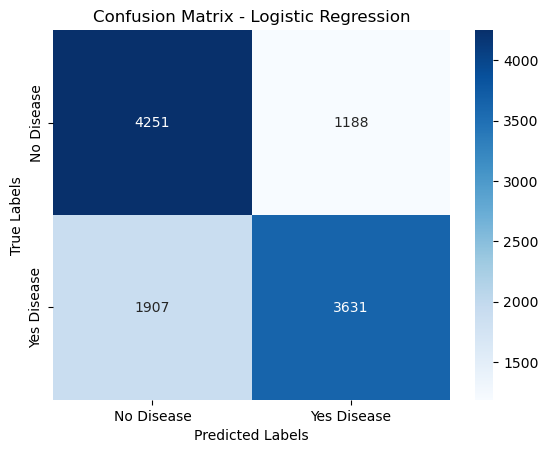

In [507]:
lr_cm = confusion_matrix(y_val, yhat_lr)
fig = sns.heatmap(lr_cm, annot=True, cmap='Blues', fmt='d')
fig.set_title('Confusion Matrix - Logistic Regression')
fig.set_xlabel('Predicted Labels')
fig.set_ylabel('True Labels')
labelsX = [item.get_text() for item in fig.get_xticklabels()]
labelsY = [item.get_text() for item in fig.get_yticklabels()]
labelsX[0] = 'No Disease'
labelsX[1] = 'Yes Disease'
labelsY[0] = 'No Disease'
labelsY[1] = 'Yes Disease'
fig.set_xticklabels(labelsX)
fig.set_yticklabels(labelsY);


In [508]:
print(classification_report(y_val, yhat_lr, target_names=['No','Yes']))

              precision    recall  f1-score   support

          No       0.69      0.78      0.73      5439
         Yes       0.75      0.66      0.70      5538

    accuracy                           0.72     10977
   macro avg       0.72      0.72      0.72     10977
weighted avg       0.72      0.72      0.72     10977



In [509]:
pr, rec, thr = precision_recall_curve(y_val, yhat_proba_lr[:,1])
precision_recall = pd.DataFrame([pr,rec,thr]).T

precision_recall = precision_recall.rename(columns={0:'precision',1:'recall',2:'threshold'})

precision_recall[(precision_recall['precision']>0.70) & (precision_recall['recall']>0.74)]

,precision,recall,threshold
4868,0.700,0.756,0.424
4869,0.700,0.756,0.424
4871,0.700,0.755,0.424
4872,0.700,0.755,0.424
4873,0.700,0.755,0.424
...,...,...,...
5051,0.709,0.741,0.434
5052,0.709,0.741,0.434
5053,0.709,0.741,0.434
5054,0.709,0.740,0.434


#### Cross Validation

In [510]:
lr_f1_cv = cross_val_score(lr,X_train_scaled, y_train,
               cv=KFold(n_splits = 10),
               scoring='f1')

## 6.3 Non-Linear Models

### 6.3.1 XGBoost

#### Single

In [511]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)

#yhat_xgb = xgb.predict(X_val_scaled)
yhat_proba_xgb = xgb.predict_proba(X_val_scaled)

yhat_proba_xgb = xgb.predict_proba(X_val_scaled)
yhat_xgb = [1 if yhat_proba_xgb[i][1] > threshold else 0 for i in range(len(yhat_proba_xgb))]

yhat_results_xgb = pd.DataFrame(yhat_proba_xgb,columns=['prob0','prob1'],index=X_val_scaled.index)
yhat_results_xgb['prediction'] = yhat_xgb
yhat_results_xgb['actual'] = y_val

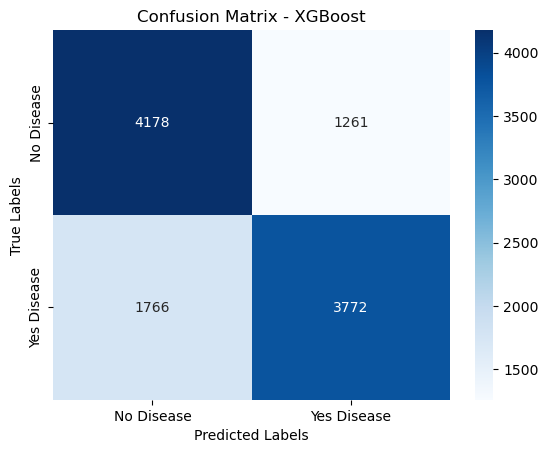

In [512]:
xgb_cm = confusion_matrix(y_val, yhat_xgb)
fig = sns.heatmap(xgb_cm, annot=True,cmap='Blues', fmt='d')
fig.set_xlabel('Predicted Labels')
fig.set_ylabel('True Labels')
fig.set_title('Confusion Matrix - XGBoost')
labelsX = [item.get_text() for item in fig.get_xticklabels()]
labelsY = [item.get_text() for item in fig.get_yticklabels()]
labelsX[0] = 'No Disease'
labelsX[1] = 'Yes Disease'
labelsY[0] = 'No Disease'
labelsY[1] = 'Yes Disease'
fig.set_xticklabels(labelsX)
fig.set_yticklabels(labelsY);

In [513]:
print(classification_report(y_val, yhat_xgb, target_names=['No','Yes']))

              precision    recall  f1-score   support

          No       0.70      0.77      0.73      5439
         Yes       0.75      0.68      0.71      5538

    accuracy                           0.72     10977
   macro avg       0.73      0.72      0.72     10977
weighted avg       0.73      0.72      0.72     10977



,precision,recall,threshold
2509,0.600,0.909,0.247
2510,0.600,0.909,0.247
2511,0.600,0.909,0.247
2512,0.600,0.909,0.248
2513,0.600,0.909,0.248
...,...,...,...
3528,0.646,0.850,0.313
3529,0.646,0.850,0.313
3530,0.646,0.850,0.313
3531,0.646,0.850,0.313


#### Cross Validation

In [515]:
xgb_f1_cv = cross_val_score(xgb,X_train_scaled, y_train,
               cv=KFold(n_splits = 10),
               scoring='f1')
xgb_f1_cv

array([0.7120698 , 0.71209947, 0.69886082, 0.7238188 , 0.72507845,
       0.71291866, 0.72481631, 0.72183353, 0.71555662, 0.71473812])

### 6.3.2 KNN

#### Single

In [516]:
knn = KNeighborsClassifier()

knn.fit(X_train_scaled, y_train)

#yhat_knn = knn.predict(X_val_scaled)
yhat_proba_knn = knn.predict_proba(X_val_scaled)

yhat_proba_knn = knn.predict_proba(X_val_scaled)
yhat_knn = [1 if yhat_proba_knn[i][1] > threshold else 0 for i in range(len(yhat_proba_knn))]

yhat_results_knn = pd.DataFrame(yhat_proba_knn,columns=['prob0','prob1'],index=X_val_scaled.index)
yhat_results_knn['prediction'] = yhat_knn
yhat_results_knn['actual'] = y_val


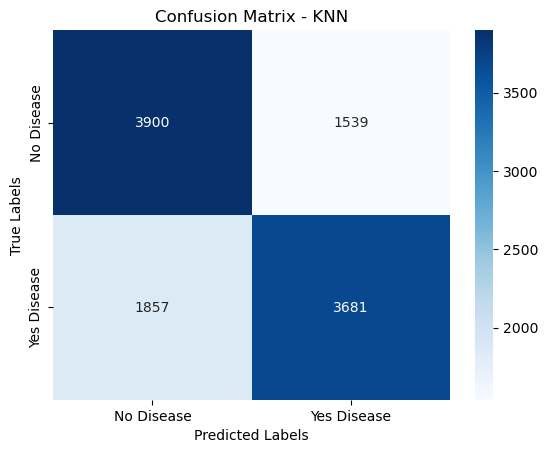

In [517]:
knn_cm = confusion_matrix(y_val, yhat_knn)
fig = sns.heatmap(knn_cm, annot=True, cmap='Blues',fmt='d');
fig.set_xlabel('Predicted Labels')
fig.set_ylabel('True Labels')
fig.set_title('Confusion Matrix - KNN')
labelsX = [item.get_text() for item in fig.get_xticklabels()]
labelsY = [item.get_text() for item in fig.get_yticklabels()]
labelsX[0] = 'No Disease'
labelsX[1] = 'Yes Disease'
labelsY[0] = 'No Disease'
labelsY[1] = 'Yes Disease'
fig.set_xticklabels(labelsX)
fig.set_yticklabels(labelsY);

In [518]:
print(classification_report(y_val, yhat_knn))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      5439
           1       0.71      0.66      0.68      5538

    accuracy                           0.69     10977
   macro avg       0.69      0.69      0.69     10977
weighted avg       0.69      0.69      0.69     10977



#### Cross Validation

In [519]:
knn_f1_cv = cross_val_score(knn,X_train_scaled, y_train,
               cv=KFold(n_splits = 10),
               scoring='f1')

In [520]:
knn_f1_cv

array([0.67114094, 0.69271924, 0.67388167, 0.68520264, 0.68488593,
       0.69286213, 0.68946267, 0.68169014, 0.69693368, 0.67737364])

### 6.3.3 LightGBM

#### Single

In [521]:
lgbm = LGBMClassifier()

lgbm.fit(X_train_scaled, y_train)
yhat_proba_lgbm = lgbm.predict_proba(X_val_scaled)

yhat_lgbm = [1 if yhat_proba_lgbm[i][1] > threshold else 0 for i in range(len(yhat_proba_lgbm))]

yhat_results_lgbm = pd.DataFrame(yhat_proba_lgbm,columns=['prob0','prob1'],index=X_val_scaled.index)
yhat_results_lgbm['prediction'] = yhat_lgbm
yhat_results_lgbm['actual'] = y_val

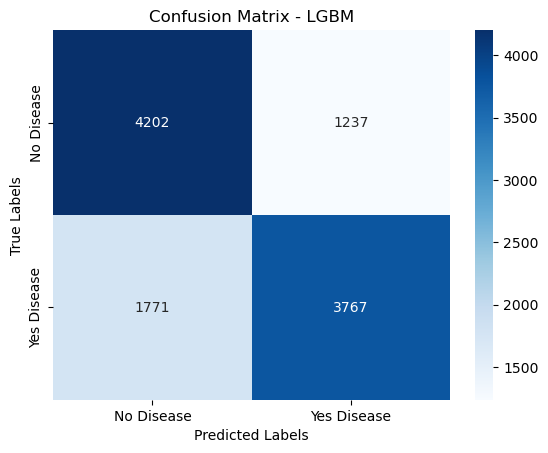

In [522]:
lgbm_cm = confusion_matrix(y_val, yhat_lgbm)
fig = sns.heatmap(lgbm_cm, annot=True, cmap='Blues',fmt='d');
fig.set_xlabel('Predicted Labels')
fig.set_ylabel('True Labels')
fig.set_title('Confusion Matrix - LGBM')
labelsX = [item.get_text() for item in fig.get_xticklabels()]
labelsY = [item.get_text() for item in fig.get_yticklabels()]
labelsX[0] = 'No Disease'
labelsX[1] = 'Yes Disease'
labelsY[0] = 'No Disease'
labelsY[1] = 'Yes Disease'
fig.set_xticklabels(labelsX)
fig.set_yticklabels(labelsY);

In [523]:
print(classification_report(y_val, yhat_lgbm))

              precision    recall  f1-score   support

           0       0.70      0.77      0.74      5439
           1       0.75      0.68      0.71      5538

    accuracy                           0.73     10977
   macro avg       0.73      0.73      0.73     10977
weighted avg       0.73      0.73      0.73     10977



#### Cross Validation

In [644]:
lgbm_f1_cv = cross_val_score(lgbm,X_train_scaled, y_train,
               cv=KFold(n_splits = 10),
               scoring='f1')

lgbm_f1_cv.mean()

0.719589279305752

### 6.3.4 Random Forest

#### Single

In [527]:
rf = RandomForestClassifier()

rf.fit(X_train_scaled, y_train)

yhat_proba_rf = rf.predict_proba(X_val_scaled)

yhat_rf = [1 if yhat_proba_rf[i][1] > threshold else 0 for i in range(len(yhat_proba_rf))]

yhat_results_rf = pd.DataFrame(yhat_proba_lgbm,columns=['prob0','prob1'],index=X_val_scaled.index)
yhat_results_rf['prediction'] = yhat_rf
yhat_results_rf['actual'] = y_val

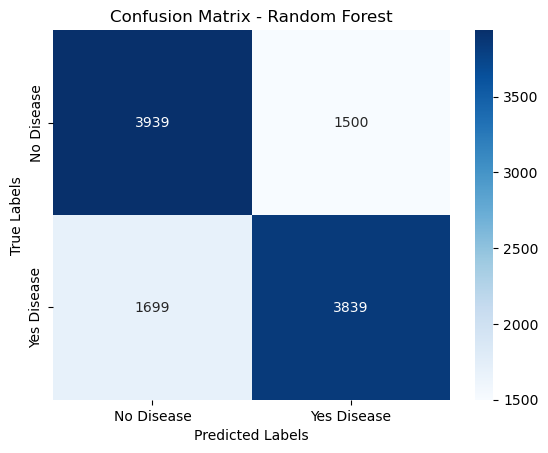

In [528]:
rf_cm = confusion_matrix(y_val, yhat_rf)
fig = sns.heatmap(rf_cm, annot=True, cmap='Blues',fmt='d');
fig.set_xlabel('Predicted Labels')
fig.set_ylabel('True Labels')
fig.set_title('Confusion Matrix - Random Forest')
labelsX = [item.get_text() for item in fig.get_xticklabels()]
labelsY = [item.get_text() for item in fig.get_yticklabels()]
labelsX[0] = 'No Disease'
labelsX[1] = 'Yes Disease'
labelsY[0] = 'No Disease'
labelsY[1] = 'Yes Disease'
fig.set_xticklabels(labelsX)
fig.set_yticklabels(labelsY);

In [529]:
print(classification_report(y_val, yhat_lgbm))

              precision    recall  f1-score   support

           0       0.70      0.77      0.74      5439
           1       0.75      0.68      0.71      5538

    accuracy                           0.73     10977
   macro avg       0.73      0.73      0.73     10977
weighted avg       0.73      0.73      0.73     10977



#### Cross Validation

In [530]:
rf_f1_cv = cross_val_score(rf,X_train_scaled, y_train,
               cv=KFold(n_splits = 10),
               scoring='f1')

In [531]:
rf_f1_cv

array([0.69936635, 0.70486436, 0.69144627, 0.7076412 , 0.71502106,
       0.70061941, 0.70550162, 0.70717973, 0.70479278, 0.705579  ])

## 6.4 Comparing ML Performance

### 6.4.1 Precision - Recall Curve

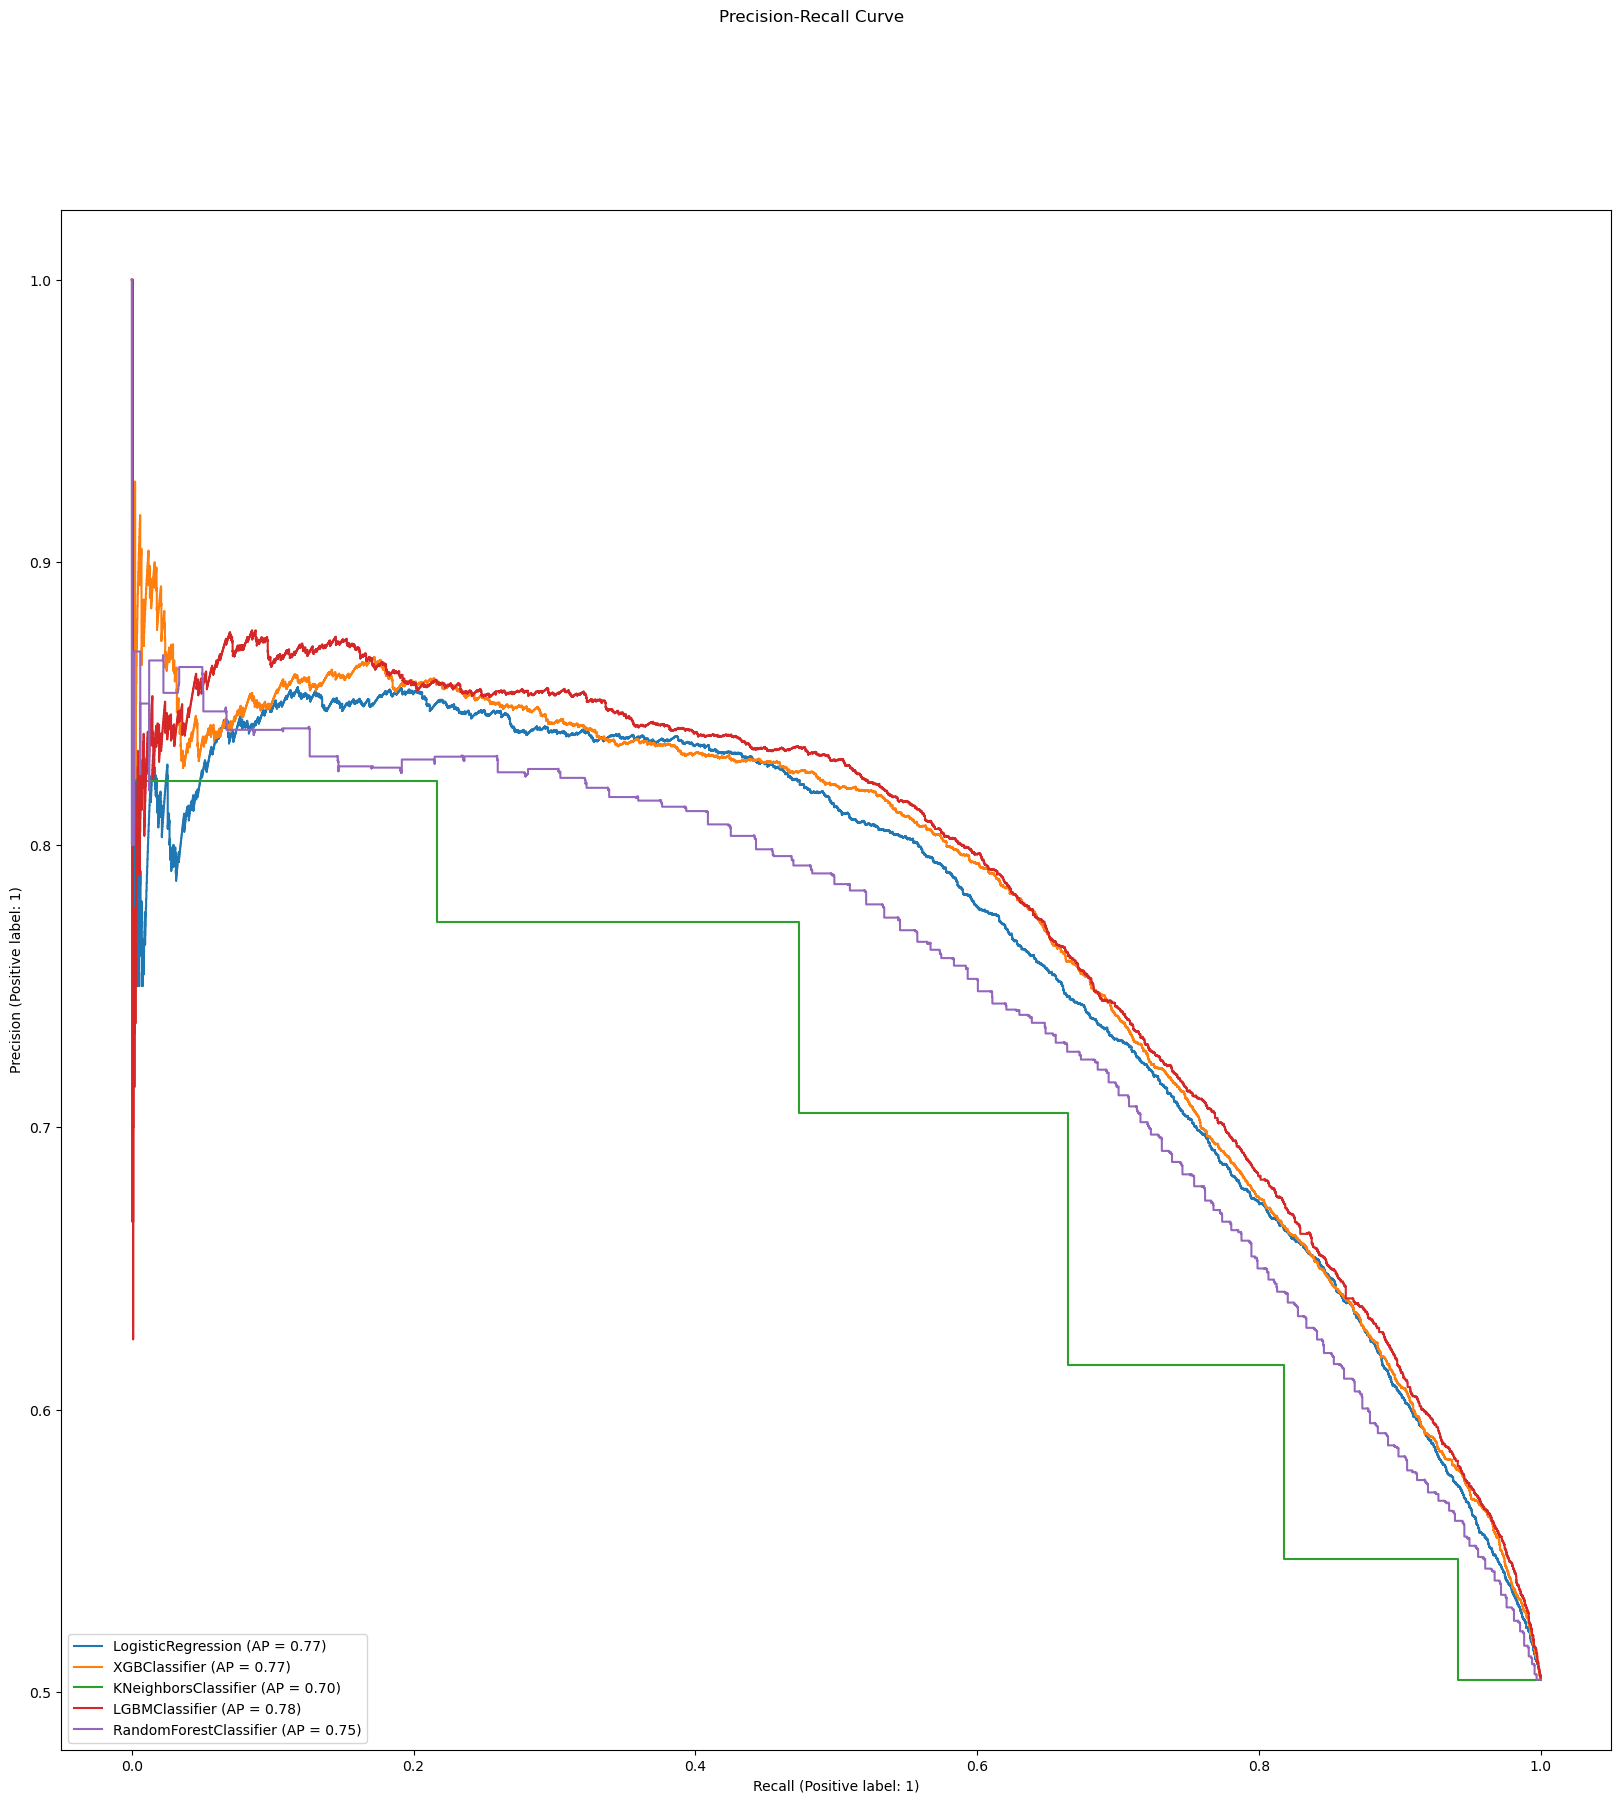

In [532]:
fig = plot_precision_recall_curve(lr, X_val_scaled, y_val)
fig = plot_precision_recall_curve(xgb, X_val_scaled, y_val, ax=fig.ax_)
fig = plot_precision_recall_curve(knn, X_val_scaled, y_val,ax=fig.ax_)
fig = plot_precision_recall_curve(lgbm, X_val_scaled, y_val,ax=fig.ax_)
fig = plot_precision_recall_curve(rf, X_val_scaled, y_val,ax=fig.ax_)

fig.figure_.suptitle('Precision-Recall Curve')
fig.figure_.set_size_inches(20,20);

### 6.4.2 Kappa Score

In [533]:
cohen_kappa_lr = cohen_kappa_score(y_val, yhat_lr)
cohen_kappa_xgb = cohen_kappa_score(y_val, yhat_xgb)
cohen_kappa_knn = cohen_kappa_score(y_val, yhat_knn)
cohen_kappa_lgbm = cohen_kappa_score(y_val, yhat_knn)
cohen_kappa_rf = cohen_kappa_score(y_val, yhat_rf)

print('Cohen Kapp Logistic Regression: {}'.format(cohen_kappa_lr))
print('Cohen Kapp XGBoost: {}'.format(cohen_kappa_xgb))
print('Cohen Kapp KNN: {}'.format(cohen_kappa_knn))
print('Cohen Kapp LGBM: {}'.format(cohen_kappa_lgbm))
print('Cohen Kapp Random Forest: {}'.format(cohen_kappa_rf))

Cohen Kapp Logistic Regression: 0.43671334523613226
Cohen Kapp XGBoost: 0.4488956884238018
Cohen Kapp KNN: 0.3815245836477732
Cohen Kapp LGBM: 0.3815245836477732
Cohen Kapp Random Forest: 0.4172880899451421


### 6.4.3 Cross-Validation Performance

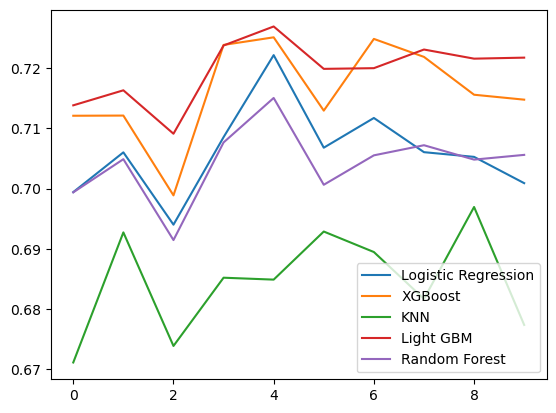

In [534]:
plt.plot(lr_f1_cv, label = 'Logistic Regression')
plt.plot(xgb_f1_cv, label = 'XGBoost')
plt.plot(knn_f1_cv, label = 'KNN')
plt.plot(lgbm_f1_cv, label = 'Light GBM')
plt.plot(rf_f1_cv, label = 'Random Forest')

plt.legend(loc='lower right')
plt.show()

In [535]:
cv_results = pd.DataFrame([lr_f1_cv, xgb_f1_cv, knn_f1_cv, lgbm_f1_cv, rf_f1_cv]).T
cv_results.rename(columns={0:'LR',1:'XGB',2:'KNN',3:'LGBM',4:'RF'},inplace=True)
cv_results

,LR,XGB,KNN,LGBM,RF
0,0.699,0.712,0.671,0.714,0.699
1,0.706,0.712,0.693,0.716,0.705
2,0.694,0.699,0.674,0.709,0.691
3,0.709,0.724,0.685,0.724,0.708
4,0.722,0.725,0.685,0.727,0.715
5,0.707,0.713,0.693,0.720,0.701
6,0.712,0.725,0.689,0.720,0.706
7,0.706,0.722,0.682,0.723,0.707
8,0.705,0.716,0.697,0.722,0.705
9,0.701,0.715,0.677,0.722,0.706


In [536]:
print('The mean F1-Score in LR cross validation are {:.3f} ± {:.3f}'.format(cv_results['LR'].mean(), cv_results['LR'].std()))
print('The mean F1-Score in XGBoost cross validation are {:.3f} ± {:.3f}'.format(cv_results['XGB'].mean(), cv_results['XGB'].std()))
print('The mean F1-Score in KNN cross validation are {:.3f} ± {:.3f}'.format(cv_results['KNN'].mean(), cv_results['KNN'].std()))
print('The mean F1-Score in LGBM cross validation are {:.3f} ± {:.3f}'.format(cv_results['LGBM'].mean(), cv_results['LGBM'].std()))
print('The mean F1-Score in RF cross validation are {:.3f} ± {:.3f}'.format(cv_results['RF'].mean(), cv_results['RF'].std()))

The mean F1-Score in LR cross validation are 0.706 ± 0.008
The mean F1-Score in XGBoost cross validation are 0.716 ± 0.008
The mean F1-Score in KNN cross validation are 0.685 ± 0.009
The mean F1-Score in LGBM cross validation are 0.720 ± 0.005
The mean F1-Score in RF cross validation are 0.704 ± 0.006


## 7.0 HP Fine Tuning

### 7.1 Search

In [537]:
params = {
        #core params
        'objective': ['binary'],
        'metric': ['average_precision'],
        'boosting':['gbdt','dart'],
        'verbosity':[-1],
        'num_leaves': [2,10,25,50,100,200],
        #'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 1],
        #'num_interactions': [50,100,150,200],
        #'max_bins':[50, 100, 300],

      #learning params
        'lambda_l1': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
        'lambda_l2': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
        'bagging_fraction': [0.2, 0.4, 0.8, 1.0],
        'bagging_freq': [1, 3, 6, 15, 20],
        'feature_fraction': [0.2, 0.4, 0.8, 1.0],
        'max_depth': [1, 2, 3],
        'min_data_in_leaf': [25,50,100,200,500],
}


In [538]:
# MAX_EVAL = 150
# kfold = KFold(n_splits=10)
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):

#     #hyperparameter tunning - random search
#     hp = {k : random.sample(v,1)[0] for k,v in params.items()}
    
#     print('Search {} - Hyperparameters '.format(i), hp)

#     #model
#     lgbm_tunned = LGBMClassifier(objective='binary', verbosity=2,
#                                  boosting= hp['boosting'],
#                                  num_leaves= hp['num_leaves'],
#                                  lambda_l1= hp['lambda_l1'],
#                                  lambda_l2= hp['lambda_l2'],
#                                  bagging_fraction= hp['bagging_fraction'],
#                                  bagging_freq= hp['bagging_freq'],
#                                  feature_fraction= hp['feature_fraction'],
#                                  max_depth= hp['max_depth'],
#                                  min_data_in_leaf= hp['min_data_in_leaf'],
#                                  )
    
#     #performance
#     result  = (cross_val_score(lgbm_tunned,X_train_scaled, y_train, cv=kfold, scoring='f1')).mean()
#     df_result = pd.DataFrame(result,index=[i],columns=['F1 Score Mean'])
#     final_result = pd.concat([final_result,df_result])
#     final_result

### 7.2 Final Model

In [640]:
threshold_final = 0.375

In [641]:
#Hyperparameters obtained from random choice => little improvement (will be enhanced by bayesian search in 2nd crisp)
tunned_params = {'objective': 'binary', 'metric': 'average_precision', 'boosting': 'gbdt', 'verbosity': -1, 'num_leaves': 50, 'lambda_l1': 10.0, 'lambda_l2': 10.0, 'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 1.0, 'max_depth': 3, 'min_data_in_leaf': 50}

#setting new model with new parameters
lgbm_final = LGBMClassifier(**tunned_params)

#training
lgbm_final.fit(X_train_scaled, y_train)

#predict
yhat_proba_final = lgbm_final.predict_proba(X_val_scaled)

yhat_results_final = pd.DataFrame(yhat_proba_final,columns=['ProbNo','ProbYes'],index=X_val_scaled.index)

#threshold tuning
yhat_results_final['prediction'] = [1 if yhat_proba_final[i][1] >= threshold_final else 0 for i in range(len(yhat_proba_final))]
yhat_results_final['real'] = y_val


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


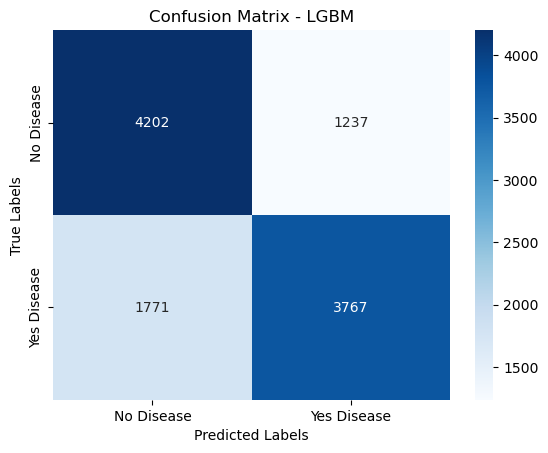

In [642]:
lgbm_cm_final = confusion_matrix(y_val, yhat_results_final['prediction'])
fig = sns.heatmap(lgbm_cm, annot=True, cmap='Blues',fmt='d');
fig.set_xlabel('Predicted Labels')
fig.set_ylabel('True Labels')
fig.set_title('Confusion Matrix - LGBM')
labelsX = [item.get_text() for item in fig.get_xticklabels()]
labelsY = [item.get_text() for item in fig.get_yticklabels()]
labelsX[0] = 'No Disease'
labelsX[1] = 'Yes Disease'
labelsY[0] = 'No Disease'
labelsY[1] = 'Yes Disease'
fig.set_xticklabels(labelsX)
fig.set_yticklabels(labelsY);

In [643]:
print(classification_report(y_val, yhat_results_final['prediction']))

              precision    recall  f1-score   support

           0       0.75      0.63      0.68      5439
           1       0.69      0.80      0.74      5538

    accuracy                           0.71     10977
   macro avg       0.72      0.71      0.71     10977
weighted avg       0.72      0.71      0.71     10977



In [635]:
pr, rec, thr = precision_recall_curve(y_val, yhat_proba_final[:,1])
precision_recall = pd.DataFrame([pr,rec,thr]).T

precision_recall = precision_recall.rename(columns={0:'precision',1:'recall',2:'threshold'})

precision_recall[(precision_recall['precision']>0.67) & (precision_recall['recall']>0.8)]

,precision,recall,threshold
3223,0.670,0.823,0.355
3224,0.671,0.823,0.355
3225,0.671,0.823,0.355
3226,0.671,0.823,0.355
3227,0.671,0.823,0.356
...,...,...,...
3459,0.685,0.801,0.375
3460,0.685,0.801,0.375
3461,0.685,0.800,0.375
3462,0.685,0.800,0.375


In [620]:
yhat_results_final['precision'] = yhat_results_final.apply(lambda x: x['ProbNo'] if x['prediction']==0 else x['ProbYes'],axis=1)

yhat_results_final['profit'] = yhat_results_final.apply(lambda x: calculate_profit(x['precision']),axis=1)

In [622]:
print('The mean precision is {}% ± {} resulting a total profit/loss USD {} what means an  average of USD {} profit/loss per exam'
                                                                                 .format(
                                                                                 np.round(yhat_results_final['precision'].mean()*100,2), 
                                                                                 np.round(yhat_results_final['precision'].std()*100,2),
                                                                                 np.round(yhat_results_final['profit'].sum(),2),
                                                                                 np.round(yhat_results_final['profit'].sum()/yhat_results_final.shape[0],2)))


The mean precision is 71.49% ± 15.04 resulting a total profit/loss USD 15886500 what means an  average of USD 1447.25 profit/loss per exam
